In [1]:
%cd ..

/home/radaimi/Documents/influence-release-master


In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import os

from tensorflow.contrib.learn.python.learn.datasets import base
import IPython

from subprocess import call

from keras.preprocessing import image

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)
import sys
sys.path.append("/home/radaimi/Documents/influence-release-master")

from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad
from scripts.load_animals import load_animals
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from sklearn.metrics.pairwise import rbf_kernel

from influence.InceptionResNetModel import BinaryInceptionResNetModel
from influence.smooth_hinge import SmoothHinge
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.dataset as dataset
from influence.dataset import DataSet
from influence.dataset_poisoning import generate_inception_features

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
num_classes = 2
num_train_ex_per_class = 900
num_test_ex_per_class = 300

model_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    classes=['dog', 'fish'])

Loading animals from disk...


In [6]:
X_train = image_data_sets.train.x
X_test = image_data_sets.test.x
Y_train = image_data_sets.train.labels * 2 - 1
Y_test = image_data_sets.test.labels * 2 - 1

In [5]:
def get_Y_pred_correct_resnet(model):
    Y_test = model.data_sets.test.labels
    if np.min(Y_test) < -0.5:
        Y_test = (np.copy(Y_test) + 1) / 2        
    Y_pred = model.sess.run(model.preds, feed_dict=model.all_test_feed_dict)
    Y_pred_correct = np.zeros([len(Y_test)])
    for idx, label in enumerate(Y_test):
        Y_pred_correct[idx] = Y_pred[idx, int(label)]
    return Y_pred_correct


num_train = X_train.shape[0]
num_test = X_test.shape[0]

X_stacked = np.vstack((X_train, X_test))

gamma = 0.05
weight_decay = 0.0001

K = rbf_kernel(X_stacked, gamma = gamma / num_train)

L = slin.cholesky(K, lower=True)
L_train = L[:num_train, :num_train]
L_test = L[num_train:, :num_train]

### Compare top 5 influential examples from each network

test_idx = 462

## RBF

input_channels = 1
weight_decay = 0.001
batch_size = num_train
initial_learning_rate = 0.001 
keep_probs = None
max_lbfgs_iter = 1000
use_bias = False
decay_epochs = [1000, 10000]

tf.reset_default_graph()

X_train = image_data_sets.train.x
Y_train = image_data_sets.train.labels * 2 - 1
train = DataSet(L_train, Y_train)
test = DataSet(L_test, Y_test)

data_sets = base.Datasets(train=train, validation=None, test=test)
input_dim = data_sets.train.x.shape[1]

# Train with hinge
rbf_model = SmoothHinge(
    temp=0,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='dogfish_rbf_hinge_t-0')
    
rbf_model.train()
hinge_W = rbf_model.sess.run(rbf_model.params)[0]

# Then load weights into smoothed version
tf.reset_default_graph()
rbf_model = SmoothHinge(
    temp=0.001,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='dogfish_rbf_hinge_t-0.001')

params_feed_dict = {}
params_feed_dict[rbf_model.W_placeholder] = hinge_W
rbf_model.sess.run(rbf_model.set_params_op, feed_dict=params_feed_dict)

rbf_predicted_loss_diffs = rbf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(rbf_model.data_sets.train.labels)),
    force_refresh=True)


## ResNet50

dataset_name = 'dogfish_900_300'

# Generate ResNet50 features
img_side = 299
num_channels = 3
num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100


tf.reset_default_graph()
full_model_name = '%s_resnet' % dataset_name
full_model = BinaryInceptionResNetModel(
    img_side=img_side,
    num_channels=num_channels,
    weight_decay=weight_decay,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=image_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=True,
    train_dir='output',
    log_dir='log',
    model_name=full_model_name)

train_inception_features_val = generate_inception_features(
    full_model, 
    image_data_sets.train.x, 
    image_data_sets.train.labels, 
    batch_size=batch_size)        
test_inception_features_val = generate_inception_features(
    full_model, 
    image_data_sets.test.x, 
    image_data_sets.test.labels, 
    batch_size=batch_size)  

train = DataSet(
    train_inception_features_val,
    image_data_sets.train.labels)
test = DataSet(
    test_inception_features_val,
    image_data_sets.test.labels)

# train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
# train = DataSet(train_f['inception_features_val'], train_f['labels'])
# test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
# test = DataSet(test_f['inception_features_val'], test_f['labels'])

validation = None

data_sets = base.Datasets(train=train, validation=validation, test=test)

# train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
# train = DataSet(train_f['inception_features_val'], train_f['labels'])
# test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
# test = DataSet(test_f['inception_features_val'], test_f['labels'])
# validation = None

# data_sets = base.Datasets(train=train, validation=validation, test=test)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 1800
Using normal model
SVM training took 25 iter.
After SVM training: 
Train loss (w reg) on all data: 0.61188793
Train loss (w/o reg) on all data: 0.37685642
Test loss (w/o reg) on all data: 0.74733716
Train acc on all data:  0.92
Test acc on all data:   0.7083333333333334
Norm of the mean of gradients: 0.008666405
Norm of the params: 21.680937
Total number of parameters: 1800
Norm of test gradient: 0.57139254
Function value: -30.767854690551758
Split function value: 30.76764488220215, -61.5355
Predicted loss diff on train_idx 5: 0.006653725306193034
Function value: -31.011821746826172
Split function value: 30.52203369140625, -61.533855
Predicted loss diff on train_idx 5: 0.006637823846605089
Function value: -31.039052963256836
Split function value: 30.498273849487305, -61.537327
Predicted loss diff on train_idx 5: 0.0066229364607069225
F

/home/radaimi/Documents/influence-release-master/influence_env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(1800, 268203)
(600, 268203)


In [7]:

input_dim = 1536
weight_decay = 0.001
batch_size = 1000
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
num_classes = 2

tf.reset_default_graph()

resnet_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='%s_resnet_onlytop' % dataset_name)

resnet_model.train()

resnet_predicted_loss_diffs = resnet_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(resnet_model.data_sets.train.labels)),
    force_refresh=True)

x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]


distances = dataset.find_distances(x_test, X_train)
flipped_idx = Y_train != y_test
rbf_margins_test = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_test_feed_dict)
rbf_margins_train = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_train_feed_dict)
resnet_Y_pred_correct = get_Y_pred_correct_resnet(resnet_model)


np.savez(
    'output/resnet_results', 
    test_idx=test_idx,
    distances=distances,
    flipped_idx=flipped_idx,
    rbf_margins_test=rbf_margins_test,
    rbf_margins_train=rbf_margins_train,
    resnet_Y_pred_correct=resnet_Y_pred_correct,
    rbf_predicted_loss_diffs=rbf_predicted_loss_diffs,
    resnet_predicted_loss_diffs=resnet_predicted_loss_diffs
)

Total number of parameters: 1536
Using normal model
LBFGS training took [46] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.015791118
Train loss (w/o reg) on all data: 0.0057617915
Test loss (w/o reg) on all data: 0.02447188
Train acc on all data:  1.0
Test acc on all data:   0.9916666666666667
Norm of the mean of gradients: 2.5029674e-06
Norm of the params: 4.4786887
Norm of test gradient: 0.106864095
Function value: -0.6967779397964478
Split function value: 0.6967746019363403, -1.3935525
Predicted loss diff on train_idx 5: -3.4907770653565723e-06
Function value: -0.7956869006156921
Split function value: 0.8023610711097717, -1.598048
Predicted loss diff on train_idx 5: -4.053488891157839e-06
Function value: -0.8006607294082642
Split function value: 0.785753607749939, -1.5864143
Predicted loss diff on train_idx 5: -3.547842821313275e-06
Function value: -0.8013694882392883
Split function value: 0.8026431202888489, -1.6040126
Predicted loss diff on train_idx 5: -3.63

In [8]:
f = np.load('output/resnet_results.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
resnet_Y_pred_correct = f['resnet_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
resnet_predicted_loss_diffs = f['resnet_predicted_loss_diffs']

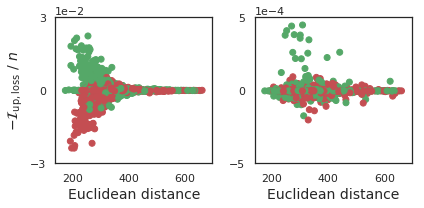

In [9]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, resnet_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
plt.savefig('fig-rbf-resnet-dist.png', dpi=600, bbox_inches='tight')

Test image:
1.0 0.9900307 0.9904852509498596


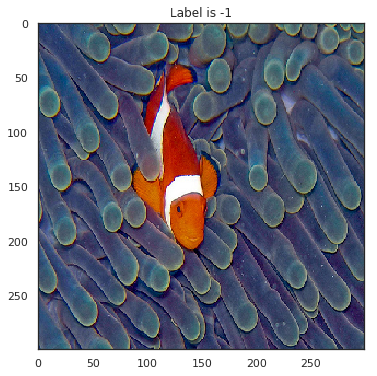

Top from RBF:
1103 1.0 194.05157 0.28052014 0.01816176520453559
1700 1.0 231.3802 0.20581147 0.018329910702175566
286 1.0 206.63591 0.6800409 0.020471102396647137
765 1.0 214.33142 -0.3200709 0.021519989437527125
925 1.0 254.57011 0.44896263 0.02236267513699002


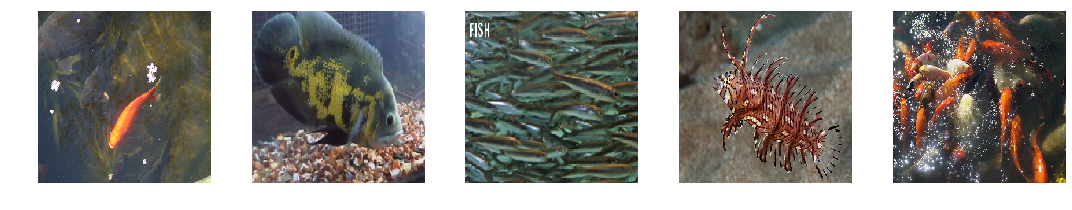

Top from Inception ReNet V2:
1380 1.0 308.69556 0.0004480563931994968
1720 1.0 395.94437 0.0005783744653066
203 1.0 301.6817 0.0005972042348649767
741 1.0 323.79434 0.0006909707519743177
550 1.0 325.7334 0.0010607621404859755


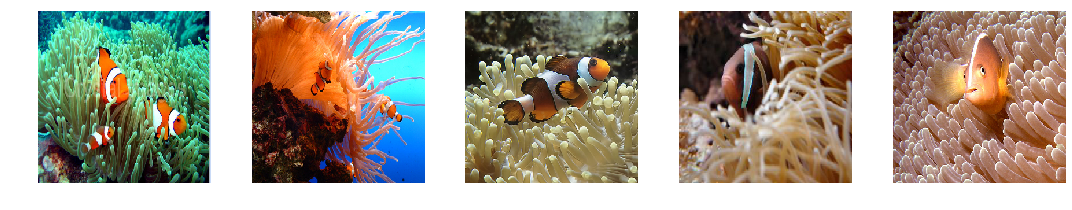

Dogs:
22 1695 -1.0 274.2589 9.316411283281115e-05
23 501 -1.0 357.82086 8.907638490200042e-05
25 1088 -1.0 371.66037 8.070917593108283e-05
31 509 -1.0 263.55902 6.927955481741163e-05
33 491 -1.0 265.4889 6.300537122620476e-05


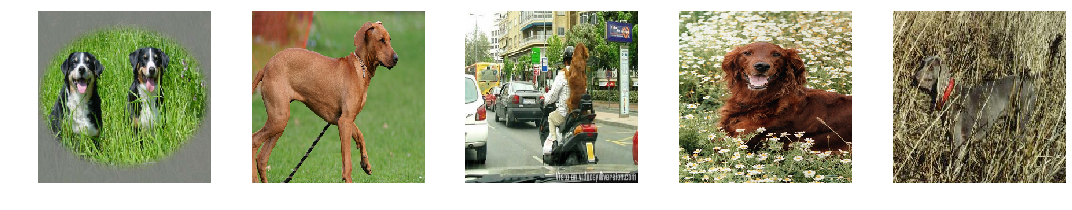

In [11]:
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], resnet_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('fig-rbf-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception ReNet V2:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(resnet_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], resnet_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-inception-resnet-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Dogs:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(resnet_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == -1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], resnet_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
plt.savefig('fig-inception-resnet-dogs.png', dpi=600, bbox_inches='tight')
plt.show()

Norm of test gradient: 0.45071656
Function value: -44.80119705200195
Split function value: 44.80141830444336, -89.602615
Predicted loss diff on train_idx 5: 0.008441294034322103
Function value: -44.91183090209961
Split function value: 44.69021987915039, -89.60205
Predicted loss diff on train_idx 5: 0.008427539931403267
Function value: -44.94613265991211
Split function value: 44.71842575073242, -89.66456
Predicted loss diff on train_idx 5: 0.008404622607760958
Function value: -44.95133972167969
Split function value: 44.736473083496094, -89.68781
Predicted loss diff on train_idx 5: 0.008413939476013184
Function value: -44.95787811279297
Split function value: 44.84852600097656, -89.806404
Predicted loss diff on train_idx 5: 0.008432507514953613
Function value: -44.95854568481445
Split function value: 44.9295539855957, -89.8881
Predicted loss diff on train_idx 5: 0.00844174649980333
Function value: -44.95856475830078
Split function value: 44.95348358154297, -89.91205
Predicted loss diff on

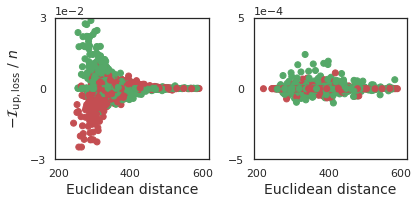

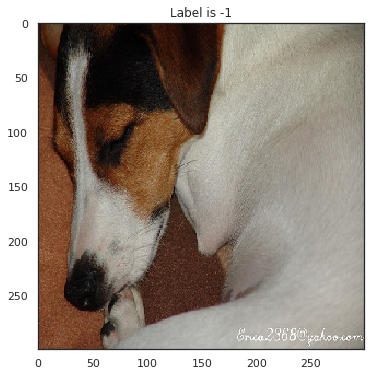

Top from RBF:
842 -1.0 281.60156 0.41960788 0.03202946980794271
1781 -1.0 257.7711 0.9116485 0.03566861894395616
477 -1.0 257.3073 0.96450627 0.037523167928059896
1387 -1.0 261.72287 0.77966654 0.041576109992133244
329 -1.0 251.58789 0.92019594 0.055458997090657554


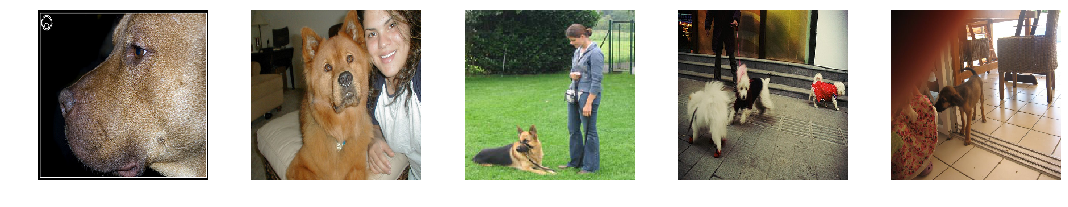

Top from Inception ResNet V2:
260 -1.0 398.10953 0.00016938745975494384
361 -1.0 357.44797 0.00017346107297473484
1072 -1.0 386.4687 0.00017787893613179526
749 -1.0 398.9992 0.00019312040673361884
575 -1.0 334.88123 0.00024050263894928825


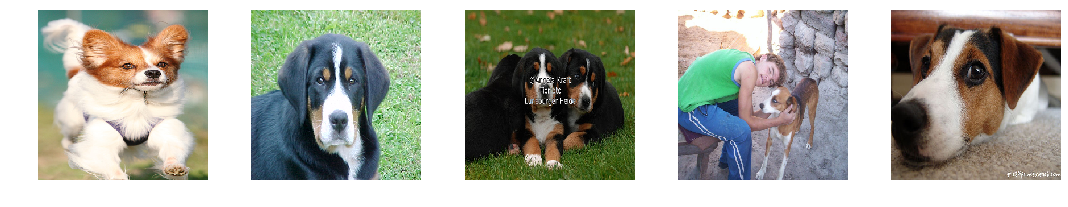

Fish:
10 1390 1.0 418.632 0.00011035922500822279
18 807 1.0 340.81305 7.349938154220581e-05
20 593 1.0 328.36078 6.713240510887569e-05
22 1141 1.0 388.71567 6.22581938902537e-05
34 658 1.0 310.10226 4.837977389494578e-05


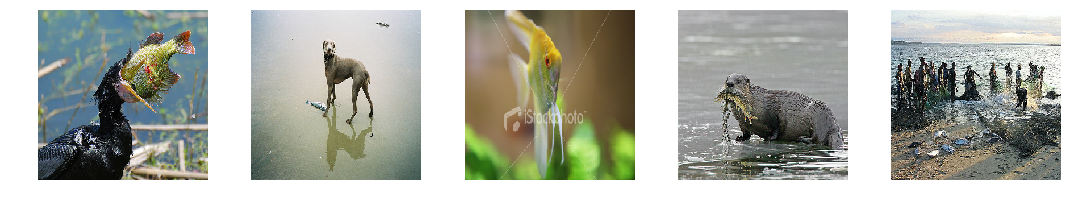

In [14]:
# Dog test image
test_idx = 500

rbf_predicted_loss_diffs = rbf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(rbf_model.data_sets.train.labels)),
    force_refresh=True)

resnet_predicted_loss_diffs = resnet_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(resnet_model.data_sets.train.labels)),
    force_refresh=True)

x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]


distances = dataset.find_distances(x_test, X_train)
flipped_idx = Y_train != y_test
rbf_margins_test = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_test_feed_dict)
rbf_margins_train = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_train_feed_dict)
resnet_Y_pred_correct = get_Y_pred_correct_resnet(resnet_model)


np.savez(
    'output/resnet_results_v2', 
    test_idx=test_idx,
    distances=distances,
    flipped_idx=flipped_idx,
    rbf_margins_test=rbf_margins_test,
    rbf_margins_train=rbf_margins_train,
    resnet_Y_pred_correct=resnet_Y_pred_correct,
    rbf_predicted_loss_diffs=rbf_predicted_loss_diffs,
    resnet_predicted_loss_diffs=resnet_predicted_loss_diffs
)

f = np.load('output/resnet_results_v2.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
resnet_Y_pred_correct = f['resnet_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
resnet_predicted_loss_diffs = f['resnet_predicted_loss_diffs']

sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, resnet_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
plt.savefig('fig-rbf-resnet-dist-dogs.png', dpi=600, bbox_inches='tight')
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], resnet_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-rbf-dogs.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception ResNet V2:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(resnet_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], resnet_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-inception-resnet-dogs-test-class.png', dpi=600, bbox_inches='tight')
plt.show()

print('Fish:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(resnet_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == 1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], resnet_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
plt.savefig('fig-inception-resnet-fishes-opp-class.png', dpi=600, bbox_inches='tight')
plt.show()